# Lab 3 Part II: Batch Normalization 


------------------------------------------------------
*Deep Learning. Master in Information Health Engineering *

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of Lab 3. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!


## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [0]:
%matplotlib inline

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 9731877.16it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142163.18it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


1654784it [00:00, 2244407.03it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


8192it [00:00, 51822.30it/s]            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw
Processing...
Done!


### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


In [0]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        
        super().__init__()
        
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)        
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm:

            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [5]:
print(0.8*len(trainset))

48000.0


In [0]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:48000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:48000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[48000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[48000:]

In [7]:
validloader.dataset

Dataset MNIST
    Number of datapoints: 12000
    Root location: /root/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [0]:
class MLP_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,nlabels,use_batch_norm)
          
        self.epochs=epochs
        
        self.lr=lr
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.criterion = nn.NLLLoss()
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = []
        
        # A list to store the loss evolution along validation
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.to(self.device)
    
        
    def trainloop(self,trainloader,validloader):
       
        # Optimization Loop
        
        for e in range(int(self.epochs)):
          
            start_time = time.time()
            
            running_loss = 0

            self.eval()
            
            for images_tr, labels_tr in trainloader:
              
                # Move input and label tensors to the default device
                images_tr, labels_tr = images_tr.to(self.device), labels_tr.to(self.device)            
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images_tr.view(images_tr.shape[0], -1))

                loss = self.criterion(out,labels_tr)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()              
                
            self.loss_during_training.append(running_loss/len(trainloader))

            self.train()
            
            # turn off gradients
            with torch.no_grad():
              
              self.eval()
              
              val_running_loss = 0
              
              for images_val, labels_val in validloader:
                
                # Move input and label tensors to the default device
                images_val, labels_val = images_val.to(self.device), labels_val.to(self.device)
                
                val_out = self.forward(images_val.view(images_val.shape[0], -1))

                val_loss = self.criterion(val_out,labels_val)

                val_running_loss += val_loss.item() 
                
              self.valid_loss_during_training.append(val_running_loss/len(validloader))

              if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time)))
            
            self.train()
            
            # acc = self.eval_performance(validloader)
            
            # model_save_name='chkp{}-p:{:f}-acc:{:.4f}.pt'.format(e,self.p,acc)
            # path = F"/content/gdrive/My Drive/MASTER HEIM/DEEP LEARNING/CHKPs/Lenet5_extended/{model_save_name}" 
            # torch.save(self.state_dict(), path)
              
                                     
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images_pf,labels_pf in dataloader:
              
                # Move input and label tensors to the default device
                images_pf, labels_pf = images_pf.to(self.device), labels_pf.to(self.device)

                probs = self.forward(images_pf.view(images_pf.shape[0], -1))
                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels_pf.view(images_pf.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

In [9]:
net_batchnorm = MLP_extended(dimx=784,hidden1=128,hidden2=64,
                              nlabels=10,epochs=10,lr=1e-3,use_batch_norm=True)
net_no_norm = MLP_extended(dimx=784,hidden1=128,hidden2=64,
                              nlabels=10,epochs=10,lr=1e-3,use_batch_norm=False)

print(net_batchnorm)
print()
print(net_no_norm)

MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)

MLP_extended(
  (output1): Linear(in_features=784, out_features=128, bias=True)
  (output2): Linear(in_features=128, out_features=64, bias=True)
  (output3): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)


> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

In [10]:
import time

net_batchnorm.trainloop(trainloader,validloader)

train_performance = net_batchnorm.eval_performance(trainloader)

test_performance = net_batchnorm.eval_performance(validloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Epoch 0. Training loss: 0.426165, Validation loss: 0.259946, Time per epoch: 13.291612 seconds
Epoch 1. Training loss: 0.203334, Validation loss: 0.149706, Time per epoch: 13.606981 seconds
Epoch 2. Training loss: 0.149785, Validation loss: 0.178710, Time per epoch: 13.661529 seconds
Epoch 3. Training loss: 0.118043, Validation loss: 0.130665, Time per epoch: 13.493845 seconds
Epoch 4. Training loss: 0.100342, Validation loss: 0.127332, Time per epoch: 13.536922 seconds
Epoch 5. Training loss: 0.091056, Validation loss: 0.112915, Time per epoch: 13.548116 seconds
Epoch 6. Training loss: 0.080124, Validation loss: 0.131361, Time per epoch: 13.502932 seconds
Epoch 7. Training loss: 0.070312, Validation loss: 0.126154, Time per epoch: 13.581741 seconds
Epoch 8. Training loss: 0.063086, Validation loss: 0.104089, Time per epoch: 13.496678 seconds
Epoch 9. Training loss: 0.059365, Validation loss: 0.110531, Time per epoch: 13.506092 seconds
Train Accuracy 0.860812
Test Accuracy 0.861785


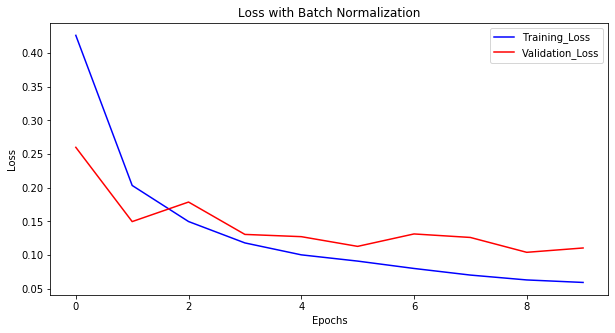

In [11]:
loss_tr_batchNorm = np.asarray(net_batchnorm.loss_during_training)
loss_val_batchNorm = np.asarray(net_batchnorm.valid_loss_during_training)

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,10,1),loss_tr_batchNorm,'b', label='Training_Loss')
plt.plot(np.arange(0,10,1),loss_val_batchNorm,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with Batch Normalization')
plt.legend()
plt.show()

In [12]:
net_no_norm.trainloop(trainloader,validloader)

train_performance = net_no_norm.eval_performance(trainloader)

test_performance = net_no_norm.eval_performance(validloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Epoch 0. Training loss: 0.440728, Validation loss: 0.246595, Time per epoch: 12.313814 seconds
Epoch 1. Training loss: 0.217865, Validation loss: 0.170503, Time per epoch: 12.758984 seconds
Epoch 2. Training loss: 0.158232, Validation loss: 0.138229, Time per epoch: 12.721786 seconds
Epoch 3. Training loss: 0.128319, Validation loss: 0.134748, Time per epoch: 12.815096 seconds
Epoch 4. Training loss: 0.107552, Validation loss: 0.115284, Time per epoch: 12.823092 seconds
Epoch 5. Training loss: 0.093634, Validation loss: 0.105583, Time per epoch: 12.792472 seconds
Epoch 6. Training loss: 0.080717, Validation loss: 0.114873, Time per epoch: 12.739543 seconds
Epoch 7. Training loss: 0.073530, Validation loss: 0.107186, Time per epoch: 12.855783 seconds
Epoch 8. Training loss: 0.065039, Validation loss: 0.117027, Time per epoch: 12.793859 seconds
Epoch 9. Training loss: 0.060609, Validation loss: 0.109224, Time per epoch: 12.778571 seconds
Train Accuracy 0.983229
Test Accuracy 0.970828


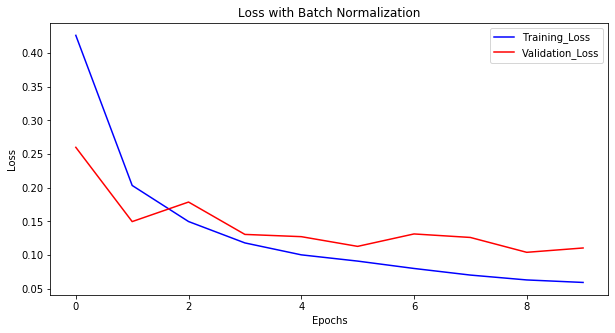

In [13]:
loss_tr_noBatchNorm = np.asarray(net_batchnorm.loss_during_training)
loss_val_noBatchNorm = np.asarray(net_batchnorm.valid_loss_during_training)

plt.figure(figsize=(10,5))
plt.plot(np.arange(0,10,1),loss_tr_noBatchNorm,'b', label='Training_Loss')
plt.plot(np.arange(0,10,1),loss_val_noBatchNorm,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with Batch Normalization')
plt.legend()
plt.show()

---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Incorporate BN to your solution of Lab 3 (Part I). Compare the results with and without BN!!

In [0]:
class Lenet5_BN(nn.Module):
    def __init__(self,dimx,nlabels,p=0.2,use_batch_norm=True):#Nlabels will be 10 in our case
        super().__init__()

        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int((((dimx-4)/2)-4)/2)
        
        # Linear layers
        
        self.output1 = nn.Linear(16*self.final_dim**2, 120)
        
        self.output2 = nn.Linear(120,84)
        
        self.output3 = nn.Linear(84,nlabels)

        #Batch_Normalization
        if self.use_batch_norm:

          self.batch_norm1=nn.BatchNorm2d(self.conv1.out_channels)

          self.batch_norm2=nn.BatchNorm2d(self.conv2.out_channels)

        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        self.prob = p
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(self.prob)
        
        
    def forward(self, x):
      
        # Pass the input tensor through the CNN operations
        x=self.conv1(x)
        if self.use_batch_norm:
          x=self.batch_norm1(x)
        x = self.pool(self.relu(x))

        x=self.conv2(x)
        if self.use_batch_norm:
          x=self.batch_norm2(x)
        x = self.pool(self.relu(x))
    
        # Flatten the tensor into a vector
        x = x.view(-1, 16*self.final_dim**2) #...view(-1,..) is to ensure 
                                               #espace because I don´t know 
                                               #how many rows I'm gonna need.
        # Pass the tensor through the Dense Layers
        x = self.output1(x)
        x = self.dropout(self.relu(x))

        x = self.output2(x)
        x = self.dropout(self.relu(x))

        x = self.logsoftmax(self.output3(x))
        
        return x


In [0]:
class Lenet5_BN_extended(Lenet5_BN):
    
    def __init__(self,dimx,nlabels,p,use_batch_norm,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,p,use_batch_norm)
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = []
        
        self.validation_loss_during_training = []
   
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:
              
              # Move input and label tensors to the default device
              images, labels = images.to(self.device), labels.to(self.device)            
                    
              self.optim.zero_grad()

              out = self.forward(images)

              loss = self.criterion(out, labels)

              running_loss += loss.item()

              loss.backward()

              self.optim.step()   

            self.loss_during_training.append(running_loss/len(trainloader))  

            print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e, self.loss_during_training[-1], (time.time() - start_time)))
            
            with torch.no_grad():
              
              validation_total = 0             

              for images,labels in validloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)
               
                validation_out = self.forward(images)
                validation_loss = self.criterion(validation_out, labels)
                validation_total += validation_loss.item()
              
              self.validation_loss_during_training.append(validation_total/len(validloader))  
              
              if(e % 1 == 0): # Every 10 epochs

                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1],self.validation_loss_during_training[-1],
                       (time.time() - start_time)))
            
            self.train()
            

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0
        
        with torch.no_grad():

            for images,labels in dataloader:

              # Move input and label tensors to the default device
              images, labels = images.to(self.device), labels.to(self.device)

              probs = self.forward(images)
              top_p, top_class = probs.topk(1, dim=1)
              equals = (top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

In [0]:
batchnorm = Lenet5_BN_extended(28,nlabels=10,p=0.2,use_batch_norm=True,epochs=30,lr=0.001)
no_batchnorm = Lenet5_BN_extended(28,nlabels=10,p=0.3,use_batch_norm=False,epochs=30,lr=0.001)

In [17]:
batchnorm.trainloop(trainloader,validloader)

train_performance = batchnorm.eval_performance(trainloader)

test_performance = batchnorm.eval_performance(validloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Epoch 0. Training loss: 0.283969, Time per epoch: 22.537269 seconds
Epoch 0. Training loss: 0.283969, Validation loss: 0.079521, Time per epoch: 25.796566 seconds
Epoch 1. Training loss: 0.079423, Time per epoch: 22.757926 seconds
Epoch 1. Training loss: 0.079423, Validation loss: 0.070352, Time per epoch: 26.051284 seconds
Epoch 2. Training loss: 0.060452, Time per epoch: 22.725441 seconds
Epoch 2. Training loss: 0.060452, Validation loss: 0.062761, Time per epoch: 25.953461 seconds
Epoch 3. Training loss: 0.050138, Time per epoch: 22.693110 seconds
Epoch 3. Training loss: 0.050138, Validation loss: 0.058870, Time per epoch: 25.941042 seconds
Epoch 4. Training loss: 0.041787, Time per epoch: 22.899459 seconds
Epoch 4. Training loss: 0.041787, Validation loss: 0.057241, Time per epoch: 26.116328 seconds
Epoch 5. Training loss: 0.037111, Time per epoch: 22.940904 seconds
Epoch 5. Training loss: 0.037111, Validation loss: 0.057391, Time per epoch: 26.137448 seconds
Epoch 6. Training loss

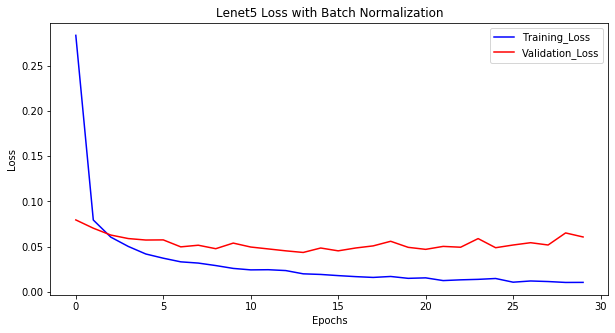

In [22]:
loss_tr_noBatchNorm = np.asarray(batchnorm.loss_during_training)
loss_val_noBatchNorm = np.asarray(batchnorm.validation_loss_during_training)

plt.figure(figsize=(10,5))
plt.plot(loss_tr_noBatchNorm,'b', label='Training_Loss')
plt.plot(loss_val_noBatchNorm,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Lenet5 Loss with Batch Normalization')
plt.legend()
plt.show()

In [18]:
no_batchnorm.trainloop(trainloader,validloader)

train_performance = no_batchnorm.eval_performance(trainloader)

test_performance = no_batchnorm.eval_performance(validloader)

print("Train Accuracy %f" %(train_performance))

print("Test Accuracy %f" %(test_performance))

Epoch 0. Training loss: 0.377021, Time per epoch: 18.356921 seconds
Epoch 0. Training loss: 0.377021, Validation loss: 0.128047, Time per epoch: 21.335585 seconds
Epoch 1. Training loss: 0.107935, Time per epoch: 18.598523 seconds
Epoch 1. Training loss: 0.107935, Validation loss: 0.101161, Time per epoch: 21.495542 seconds
Epoch 2. Training loss: 0.079812, Time per epoch: 18.591640 seconds
Epoch 2. Training loss: 0.079812, Validation loss: 0.075909, Time per epoch: 21.532654 seconds
Epoch 3. Training loss: 0.064008, Time per epoch: 18.582021 seconds
Epoch 3. Training loss: 0.064008, Validation loss: 0.065912, Time per epoch: 21.460980 seconds
Epoch 4. Training loss: 0.057801, Time per epoch: 18.684697 seconds
Epoch 4. Training loss: 0.057801, Validation loss: 0.062925, Time per epoch: 21.589270 seconds
Epoch 5. Training loss: 0.050348, Time per epoch: 18.478312 seconds
Epoch 5. Training loss: 0.050348, Validation loss: 0.061241, Time per epoch: 21.356176 seconds
Epoch 6. Training loss

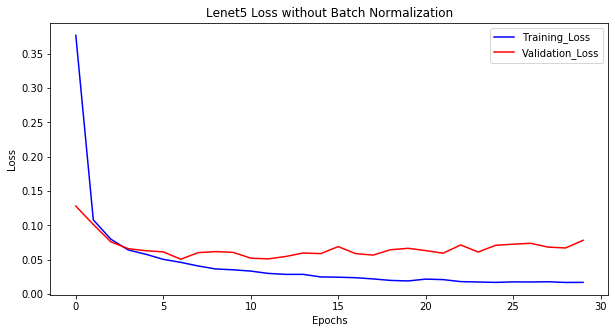

In [24]:
loss_tr_noBatchNorm = np.asarray(no_batchnorm.loss_during_training)
loss_val_noBatchNorm = np.asarray(no_batchnorm.validation_loss_during_training)
plt.figure(figsize=(10,5))
plt.plot(loss_tr_noBatchNorm,'b', label='Training_Loss')
plt.plot(loss_val_noBatchNorm,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Lenet5 Loss without Batch Normalization')
plt.legend()
plt.show()